In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Dataset Selection and Preparation

In [2]:
df=pd.read_csv('bank-additional-full.csv',delimiter=';')

In [3]:
df.head() #neetcode

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
'''
Duration: last contact duration, in seconds (numeric). Important
note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call
is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and
should be discarded if the intention is to have a realistic
predictive model.
'''
df.drop('duration',axis=1,inplace=True)

### Remove null values

In [6]:
# put the mean for numeric columns
for column in df.select_dtypes(include=[np.number]).columns:
    mean = np.mean(df[column])
    df[column].fillna(mean,inplace=True)
# put the mode for categorical columns
for column in df.columns:
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value,inplace=True)
    
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Remove outliers

In [7]:
df.shape

(41188, 20)

In [8]:
df['pdays'] = df['pdays'].replace(999, 0) # As it can affect the outliers removal
excluded_columns = ['pdays','euribor3m','previous','nr.employed']
for column in df.select_dtypes(include=[np.number]).columns:
    if column not in excluded_columns:
        Q1 = np.quantile(df[column],0.25)
        Q3 = np.quantile(df[column],0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"for column {column}: {outliers.shape[0]}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

original_df = df.copy()

for column age: 469
for column campaign: 2392
for column emp.var.rate: 0
for column cons.price.idx: 0
for column cons.conf.idx: 392


In [9]:
df.shape

(37935, 20)

# Exploratory Data Analysis (EDA)

### Numeric columns

In [10]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

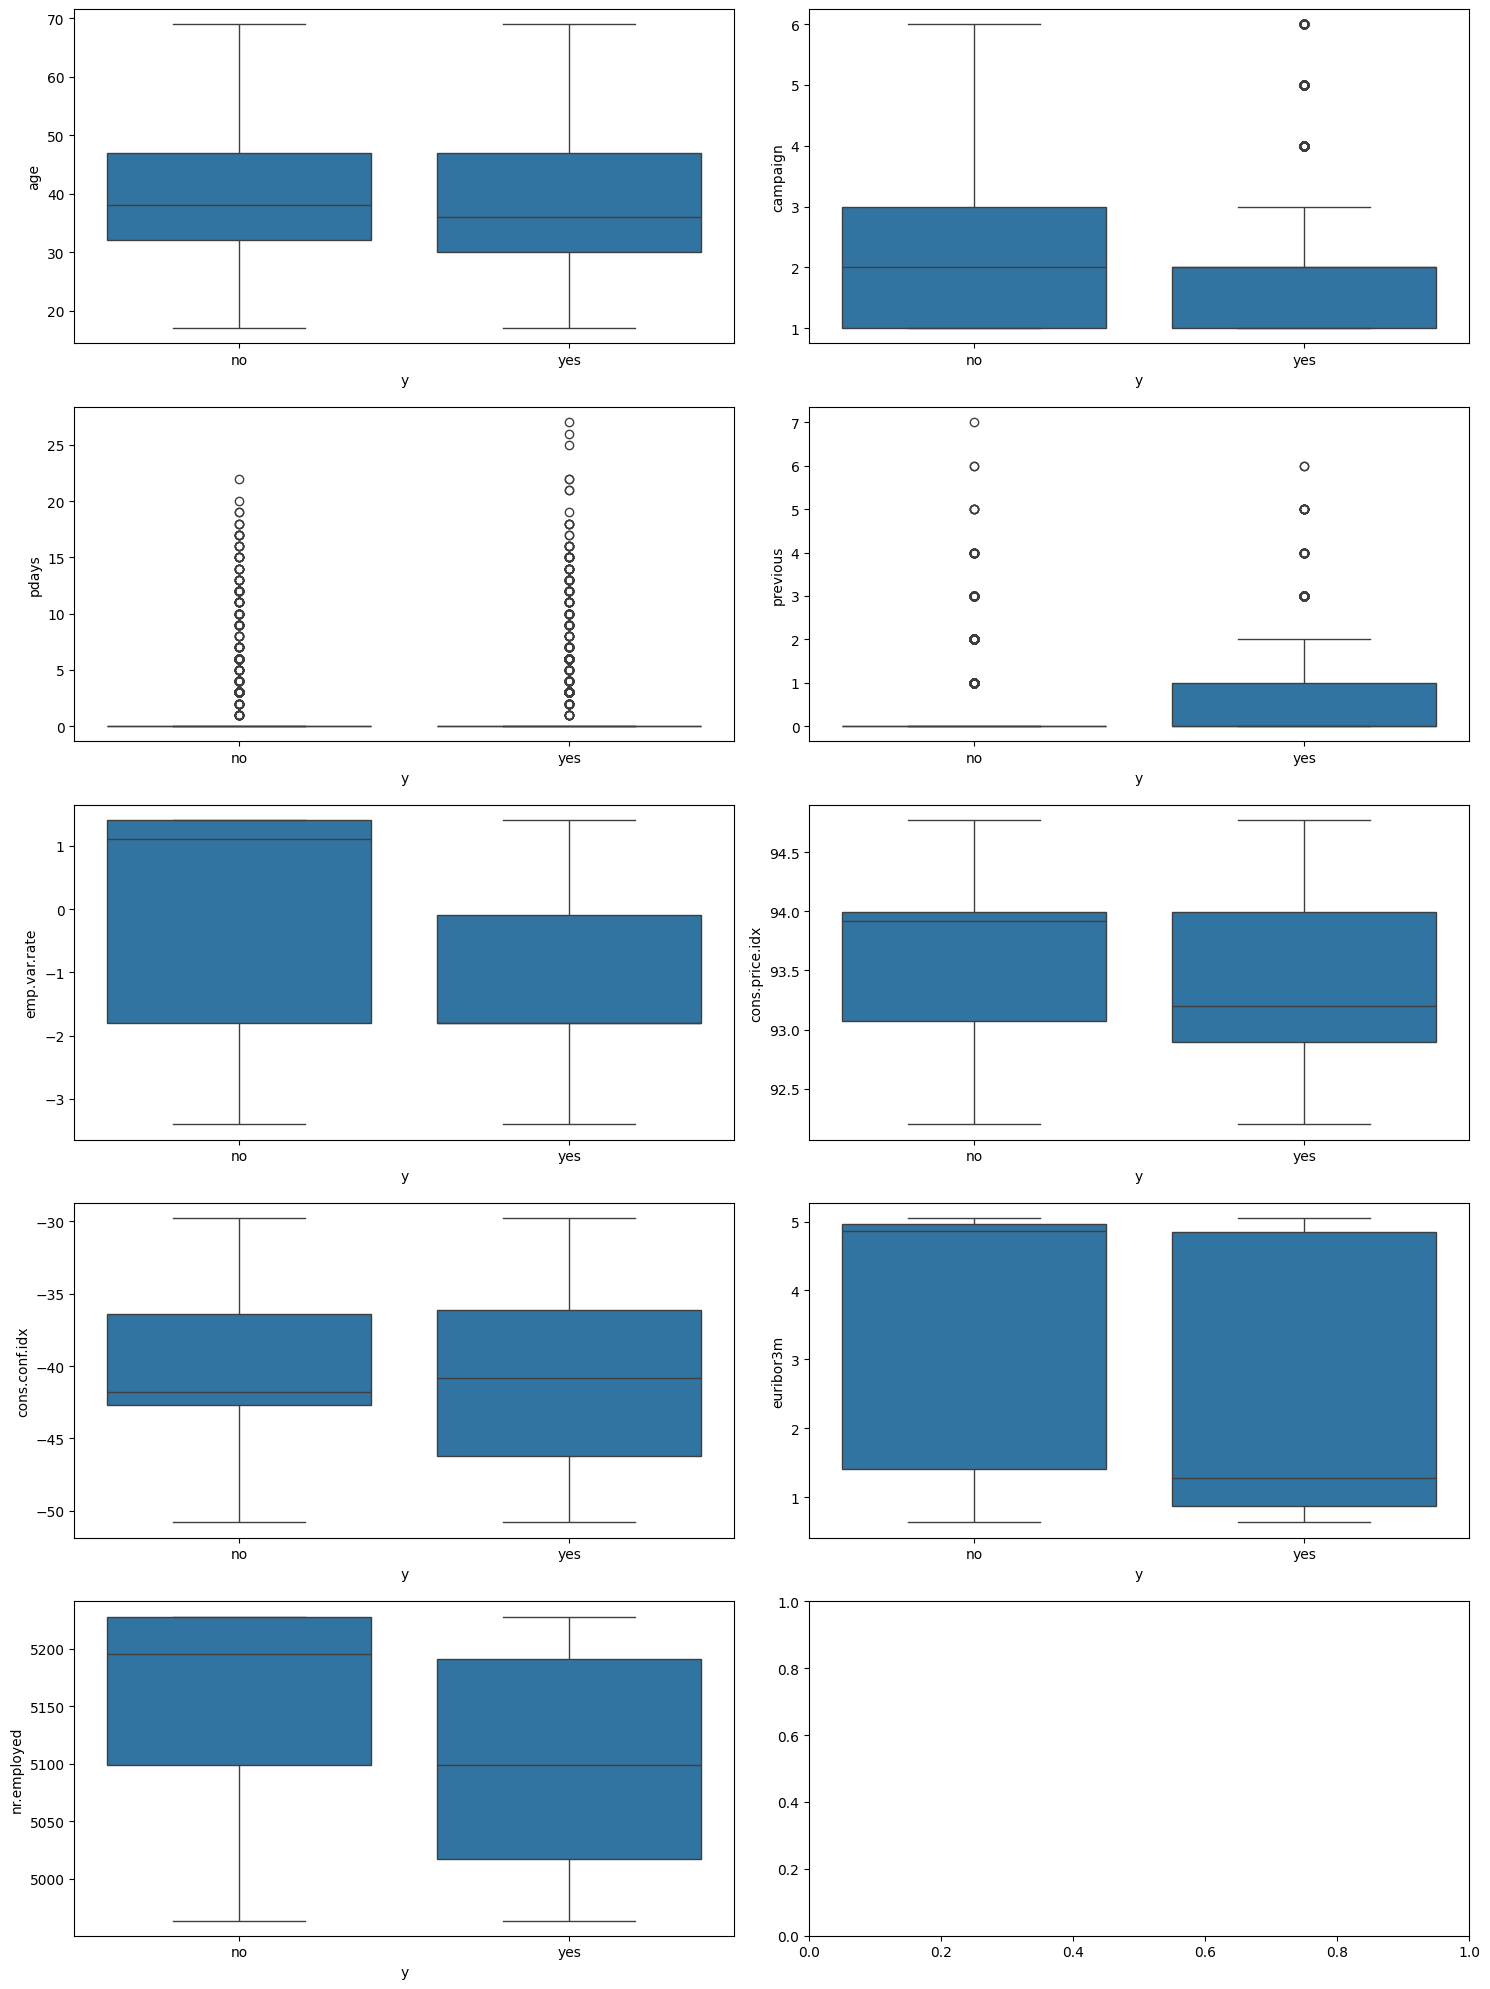

In [11]:
i = 1
fig, axes = plt.subplots(5,2,figsize = (15,20))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    if i < 9: 
        sns.boxplot(x='y', y=column, data=df, ax=axes[i])

plt.tight_layout()
plt.show()

### It is clear that the least effective columns are 'pdays', 'euribor3m'
### if previous column is 0 then it is most likely that y column would be no but when it 1 or 2 then it likely to be yes

### Categorical columns

In [12]:
categ_columns = df.select_dtypes(include=['bool','O']).columns
categ_columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

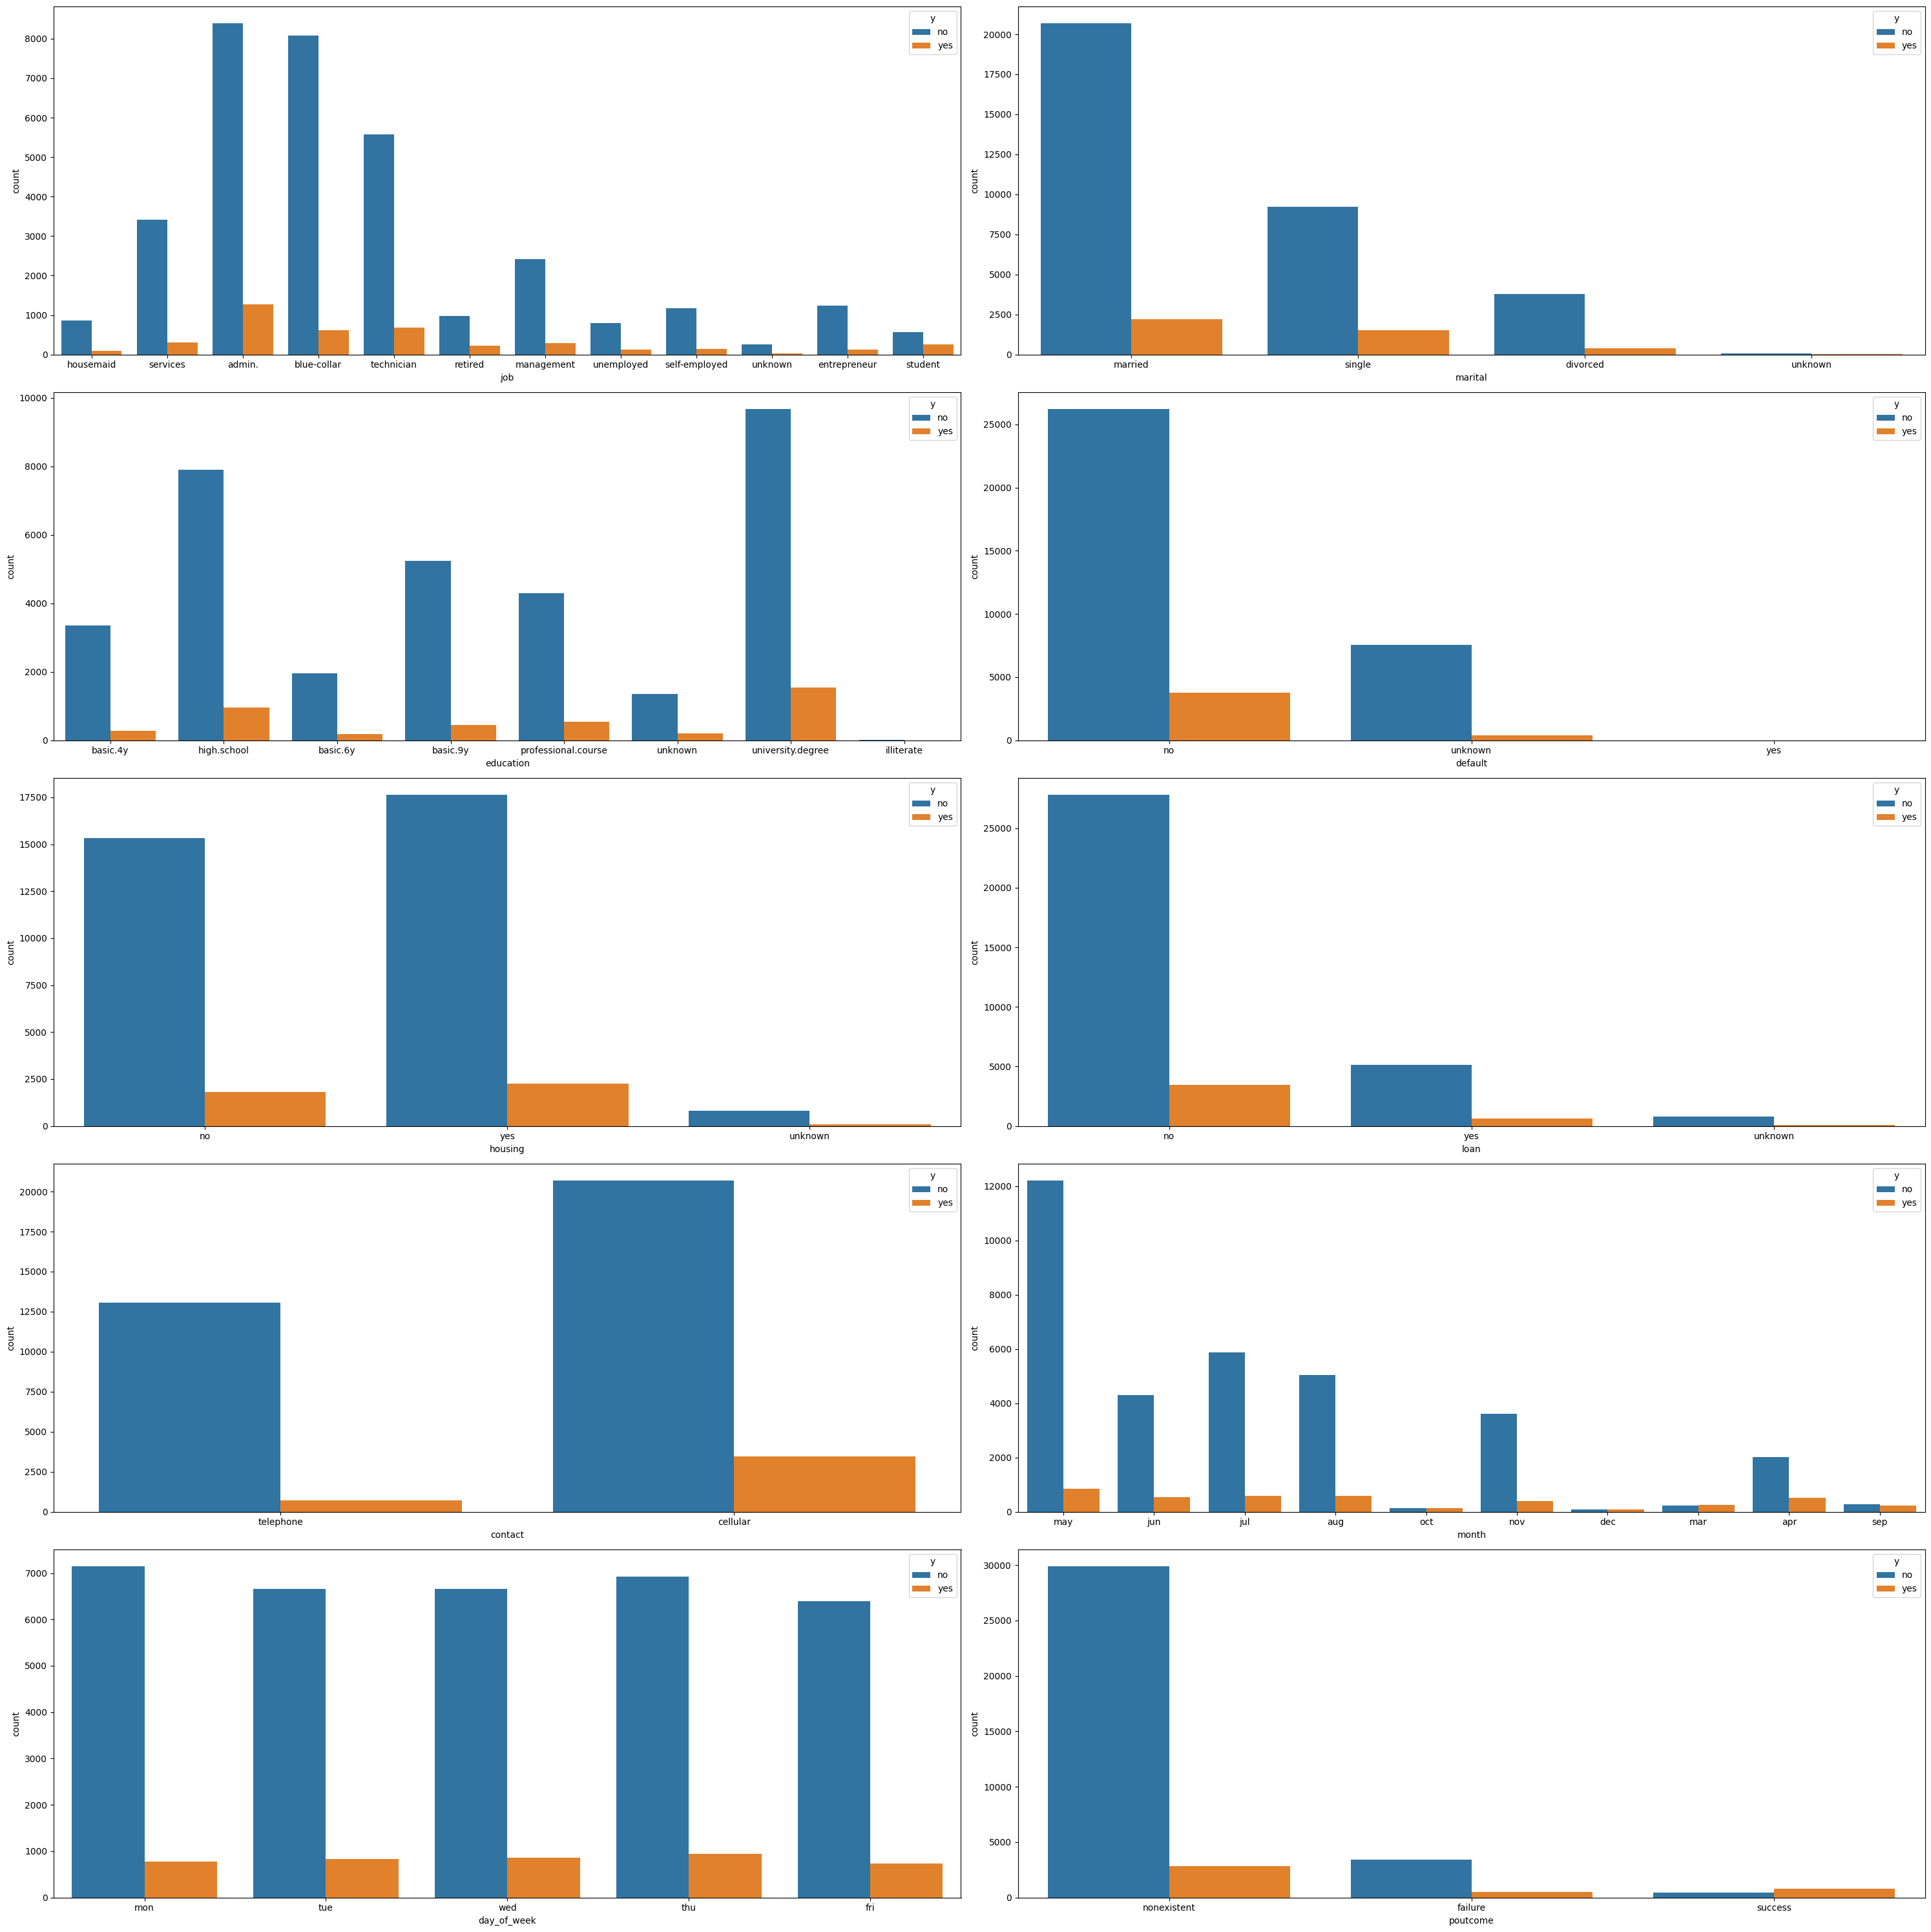

In [13]:
i = 1
fig, axes = plt.subplots(5,2,figsize = (30,30))
axes = axes.flatten()
for i,column in enumerate(categ_columns):
    if i < 10:
        sns.countplot(data=df,x=column,hue='y',ax=axes[i])
plt.tight_layout()
plt.show()

### The day_of_week columns seems to be unimportant
### When the job type is admin, marital is married, contact type is cellular, defualt has value of no, poutcome has value of nonexistent, the education is university degree, and has housing loan, then the value of y likely would be yes

# Feature Engineering

In [14]:
# try to combine Campaign and Previous columns to represent total number of contacts performed
df['total_contacts'] = df['campaign'] + df['previous']
df.drop(['campaign','previous','day_of_week'],axis=1,inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,total_contacts
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,unknown,no,no,telephone,may,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
2,37,services,married,high.school,no,yes,no,telephone,may,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
4,56,services,married,high.school,no,no,yes,telephone,may,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1


# Preprocessing for Neural Network

### Scale the data

In [15]:
numeric_columns = df.select_dtypes(include=[np.number]).columns # Update after teh feature engineering
scl = StandardScaler()
df[numeric_columns] = scl.fit_transform(df[numeric_columns])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,total_contacts
0,1.705842,housemaid,married,basic.4y,no,no,no,telephone,may,-0.159512,nonexistent,0.651579,0.730537,0.968293,0.710868,0.324823,no,-0.907695
1,1.809607,services,married,high.school,unknown,no,no,telephone,may,-0.159512,nonexistent,0.651579,0.730537,0.968293,0.710868,0.324823,no,-0.907695
2,-0.265701,services,married,high.school,no,yes,no,telephone,may,-0.159512,nonexistent,0.651579,0.730537,0.968293,0.710868,0.324823,no,-0.907695
3,0.045595,admin.,married,basic.6y,no,no,no,telephone,may,-0.159512,nonexistent,0.651579,0.730537,0.968293,0.710868,0.324823,no,-0.907695
4,1.705842,services,married,high.school,no,no,yes,telephone,may,-0.159512,nonexistent,0.651579,0.730537,0.968293,0.710868,0.324823,no,-0.907695


### Encode the data

In [16]:
# Label encoding for y, default, housing, loan, contact, poutcome
d = {'no':0,'yes':1,'unknown':2}
df[['y', 'default', 'housing', 'loan']] = df[['y', 'default', 'housing', 'loan']].map(d.get)

d = {'failure' : 0,'success' : 1,'nonexistent': 2}
df['poutcome'] = df['poutcome'].map(d.get)

d = {'cellular' : 0,'telephone' : 1}
df['contact'] = df['contact'].map(d.get)

In [17]:
# One hot encoding for job, marital, education, month
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
oheEncoded = ohe.fit_transform(df[['job','marital','education','month']])
df = pd.concat([df,oheEncoded],axis=1)
df.drop(['job','marital','education','month'],axis=1,inplace=True)
df

,age,default,housing,loan,contact,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,...,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1.705842,0,0,0,1,-0.159512,2,0.651579,0.730537,0.968293,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.809607,2,0,0,1,-0.159512,2,0.651579,0.730537,0.968293,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.265701,0,1,0,1,-0.159512,2,0.651579,0.730537,0.968293,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.045595,0,0,0,1,-0.159512,2,0.651579,0.730537,0.968293,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.705842,0,0,1,1,-0.159512,2,0.651579,0.730537,0.968293,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,-0.265701,0,1,0,0,-0.159512,2,-0.782760,2.093023,-2.282927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41182,-1.095824,0,1,0,0,6.530867,1,-0.782760,2.093023,-2.282927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41184,0.668188,0,0,0,0,-0.159512,2,-0.782760,2.093023,-2.282927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41185,1.705842,0,1,0,0,-0.159512,2,-0.782760,2.093023,-2.282927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Neural Network Development

In [18]:
# Split the train and test data
X = df.drop('y',axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

result = original_df.loc[X_test.index].copy() # To be used in insights

### Determining the best number of nodes in the hidden layer

In [19]:
for n in range(48,1,-6):
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(X_train.shape[1],activation='sigmoid',name='Input_layer'))
    model.add(layers.Dense(n,activation='relu',name='Hidden_layer'))
    model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50)
    print(f"For {n} nodes in hidden layer: \nLoss={model.evaluate(X_test,y_test)}")

Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8806 - loss: 0.3538 - val_accuracy: 0.8880 - val_loss: 0.3122
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8940 - loss: 0.2983 - val_accuracy: 0.8895 - val_loss: 0.2978
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8948 - loss: 0.2919 - val_accuracy: 0.8944 - val_loss: 0.2942
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.2921 - val_accuracy: 0.8956 - val_loss: 0.2923
Epoch 5/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9025 - loss: 0.2789 - val_accuracy: 0.8953 - val_loss: 0.2925
Epoch 6/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8998 - loss: 0.2849 - val_accuracy: 0.8959 - val_loss: 0.2899
Epoch 7/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.9012 - loss: 0.2818 - val_accuracy: 0.8963 - val_loss: 0.2896
Epoch 8/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9022 - loss: 0.2812 - val_accuracy: 

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.8965 - loss: 0.2788
For 48 nodes in hidden layer: 
Loss=[0.28499656915664673, 0.8956109285354614]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8899 - loss: 0.3574 - val_accuracy: 0.8878 - val_loss: 0.3203
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8938 - loss: 0.3030 - val_accuracy: 0.8874 - val_loss: 0.3026
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8939 - loss: 0.2935 - val_accuracy: 0.8931 - val_loss: 0.2967
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8982 - loss: 0.2885 - val_accuracy: 0.8948 - val_loss: 0.2938
Epoch 5/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.8986 - loss: 0.2876 - val_accuracy: 0.8952 - val_loss: 0.2927
Epoch 6/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8999 - loss: 0.2871 - val_accuracy: 0.8965 - val_loss: 0.2912
Epoch 7/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.9022 

Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9035 - loss: 0.2762 - val_accuracy: 0.8965 - val_loss: 0.2844
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.8972 - loss: 0.2781
For 42 nodes in hidden layer: 
Loss=[0.2843611538410187, 0.8965335488319397]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8627 - loss: 0.3763 - val_accuracy: 0.8878 - val_loss: 0.3097
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8950 - loss: 0.2930 - val_accuracy: 0.8906 - val_loss: 0.2956
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8960 - loss: 0.2909 - val_accuracy: 0.8947 - val_loss: 0.2914
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8956 - loss: 0.2913 - val_accuracy: 0.8955 - val_loss: 0.2897
Epoch 5/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9001 - loss: 0.2814 - val_accuracy: 0.8955 - val_loss: 0.2887
Epoch 6/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8993 - loss

Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9059 - loss: 0.2697 - val_accuracy: 0.8960 - val_loss: 0.2842
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9058 - loss: 0.2696 - val_accuracy: 0.8961 - val_loss: 0.2840
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.8974 - loss: 0.2778
For 36 nodes in hidden layer: 
Loss=[0.2839503884315491, 0.8961381316184998]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8891 - loss: 0.3401 - val_accuracy: 0.8878 - val_loss: 0.3145
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8916 - loss: 0.3036 - val_accuracy: 0.8884 - val_loss: 0.2986
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8945 - loss: 0.2900 - val_accuracy: 0.8923 - val_loss: 0.2938
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.8958 - loss: 0.2923 - val_accuracy: 0.8955 - val_loss: 0.2919
Epoch 5/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.9001 -

Epoch 48/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.9043 - loss: 0.2744 - val_accuracy: 0.8961 - val_loss: 0.2839
Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.9013 - loss: 0.2789 - val_accuracy: 0.8957 - val_loss: 0.2840
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.9037 - loss: 0.2731 - val_accuracy: 0.8959 - val_loss: 0.2844
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.8964 - loss: 0.2784
For 30 nodes in hidden layer: 
Loss=[0.28438472747802734, 0.8958745002746582]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8637 - loss: 0.3755 - val_accuracy: 0.8878 - val_loss: 0.3189
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8933 - loss: 0.3025 - val_accuracy: 0.8889 - val_loss: 0.2989
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.8944 - loss: 0.2929 - val_accuracy: 0.8940 - val_loss: 0.2937
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 

Epoch 47/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.9006 - loss: 0.2792 - val_accuracy: 0.8971 - val_loss: 0.2839
Epoch 48/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.9015 - loss: 0.2796 - val_accuracy: 0.8969 - val_loss: 0.2839
Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.9067 - loss: 0.2723 - val_accuracy: 0.8965 - val_loss: 0.2843
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.9017 - loss: 0.2804 - val_accuracy: 0.8961 - val_loss: 0.2839
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8973 - loss: 0.2774
For 24 nodes in hidden layer: 
Loss=[0.2839442789554596, 0.8961381316184998]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8656 - loss: 0.3783 - val_accuracy: 0.8878 - val_loss: 0.3087
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8919 - loss: 0.2968 - val_accuracy: 0.8895 - val_loss: 0.2961
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.

Epoch 46/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9044 - loss: 0.2728 - val_accuracy: 0.8965 - val_loss: 0.2842
Epoch 47/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.8990 - loss: 0.2812 - val_accuracy: 0.8973 - val_loss: 0.2842
Epoch 48/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.9018 - loss: 0.2763 - val_accuracy: 0.8965 - val_loss: 0.2840
Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.9014 - loss: 0.2788 - val_accuracy: 0.8968 - val_loss: 0.2842
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.9025 - loss: 0.2779 - val_accuracy: 0.8967 - val_loss: 0.2845
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.8979 - loss: 0.2786
For 18 nodes in hidden layer: 
Loss=[0.284510999917984, 0.8966653347015381]
Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8919 - loss: 0.3500 - val_accuracy: 0.8878 - val_loss: 0.3116
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.9036 - loss: 0.2789 - val_accuracy: 0.8964 - val_loss: 0.2835
Epoch 45/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.9068 - loss: 0.2669 - val_accuracy: 0.8956 - val_loss: 0.2852
Epoch 46/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.9030 - loss: 0.2724 - val_accuracy: 0.8964 - val_loss: 0.2837
Epoch 47/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9036 - loss: 0.2725 - val_accuracy: 0.8961 - val_loss: 0.2841
Epoch 48/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.9019 - loss: 0.2756 - val_accuracy: 0.8960 - val_loss: 0.2847
Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.9058 - loss: 0.2699 - val_accuracy: 0.8964 - val_loss: 0.2836
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.9053 - loss: 0.2670 - val_accuracy: 0.8960 - val_loss: 0.2834
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.8963 - loss: 0.2778
For 12 nodes in hidd

Epoch 43/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.9004 - loss: 0.2798 - val_accuracy: 0.8961 - val_loss: 0.2846
Epoch 44/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.9030 - loss: 0.2769 - val_accuracy: 0.8951 - val_loss: 0.2855
Epoch 45/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.9023 - loss: 0.2774 - val_accuracy: 0.8963 - val_loss: 0.2846
Epoch 46/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.9017 - loss: 0.2744 - val_accuracy: 0.8956 - val_loss: 0.2846
Epoch 47/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.9037 - loss: 0.2734 - val_accuracy: 0.8950 - val_loss: 0.2861
Epoch 48/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.9006 - loss: 0.2770 - val_accuracy: 0.8955 - val_loss: 0.2846
Epoch 49/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9046 - loss: 0.2758 - val_accuracy: 0.8960 - val_loss: 0.2854
Epoch 50/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9038 - loss: 0.276

##### For 48 nodes in hidden layer: 
##### Loss=[0.28368550539016724, 0.8966653347015381]
##### For 42 nodes in hidden layer: 
##### Loss=[0.28449058532714844, 0.8950837254524231]
##### For 36 nodes in hidden layer: 
##### Loss=[0.2838430106639862, 0.8966653347015381]
##### For 30 nodes in hidden layer: 
##### Loss=[0.28385236859321594, 0.8961381316184998]
##### For 24 nodes in hidden layer: 
##### Loss=[0.28465020656585693, 0.8960063457489014]
##### For 18 nodes in hidden layer: 
##### Loss=[0.2843298316001892, 0.8965335488319397]
##### For 12 nodes in hidden layer: 
##### Loss=[0.28417521715164185, 0.8957427144050598]
##### For 6 nodes in hidden layer: 
##### Loss=[0.2849408686161041, 0.8957427144050598]

### It is close but the best number was 48 nodes in the hidden layer

### Determining the best number of epochs

In [20]:
for epoch in [50,100,200,400,500]:
    model = Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(X_train.shape[1],activation='sigmoid',name='Input_layer'))
    model.add(layers.Dense(48,activation='relu',name='Hidden_layer'))
    model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epoch)
    print(f"For {epoch} epochs: \nLoss={model.evaluate(X_test,y_test)}")

Epoch 1/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8626 - loss: 0.3724 - val_accuracy: 0.8878 - val_loss: 0.3159
Epoch 2/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.8898 - loss: 0.3079 - val_accuracy: 0.8878 - val_loss: 0.3003
Epoch 3/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.8910 - loss: 0.2927 - val_accuracy: 0.8919 - val_loss: 0.2943
Epoch 4/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.8947 - loss: 0.2938 - val_accuracy: 0.8938 - val_loss: 0.2922
Epoch 5/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.9019 - loss: 0.2801 - val_accuracy: 0.8955 - val_loss: 0.2903
Epoch 6/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.8974 - loss: 0.2871 - val_accuracy: 0.8960 - val_loss: 0.2892
Epoch 7/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.9016 - loss: 0.2829 - val_accuracy: 0.8961 - val_loss: 0.2886
Epoch 8/50
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.9029 - loss: 0.2771 - va

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.8976 - loss: 0.2788
For 50 epochs: 
Loss=[0.28458675742149353, 0.897456169128418]
Epoch 1/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8810 - loss: 0.3575 - val_accuracy: 0.8878 - val_loss: 0.3142
Epoch 2/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.8891 - loss: 0.3077 - val_accuracy: 0.8881 - val_loss: 0.3003
Epoch 3/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.8947 - loss: 0.2904 - val_accuracy: 0.8928 - val_loss: 0.2950
Epoch 4/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.9003 - loss: 0.2808 - val_accuracy: 0.8953 - val_loss: 0.2930
Epoch 5/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8984 - loss: 0.2892 - val_accuracy: 0.8956 - val_loss: 0.2918
Epoch 6/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9000 - loss: 0.2809 - val_accuracy: 0.8959 - val_loss: 0.2907
Epoch 7/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9012 - loss: 0

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2719 - val_accuracy: 0.8956 - val_loss: 0.2847
Epoch 50/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9066 - loss: 0.2709 - val_accuracy: 0.8967 - val_loss: 0.2841
Epoch 51/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9055 - loss: 0.2695 - val_accuracy: 0.8964 - val_loss: 0.2841
Epoch 52/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9045 - loss: 0.2719 - val_accuracy: 0.8953 - val_loss: 0.2843
Epoch 53/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9056 - loss: 0.2685 - val_accuracy: 0.8957 - val_loss: 0.2847
Epoch 54/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9034 - loss: 0.2741 - val_accuracy: 0.8963 - val_loss: 0.2840
Epoch 55/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.2739 - val_accuracy: 0.8964 - val_loss: 0.2839
Epoch 56/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9041 - loss: 0.2722 - val_accuracy:

Epoch 99/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0.2692 - val_accuracy: 0.8960 - val_loss: 0.2831
Epoch 100/100
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.2703 - val_accuracy: 0.8957 - val_loss: 0.2831
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.8968 - loss: 0.2770
For 100 epochs: 
Loss=[0.283112108707428, 0.8957427144050598]
Epoch 1/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8707 - loss: 0.3568 - val_accuracy: 0.8878 - val_loss: 0.3055
Epoch 2/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8903 - loss: 0.3003 - val_accuracy: 0.8924 - val_loss: 0.2968
Epoch 3/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8963 - loss: 0.2901 - val_accuracy: 0.8948 - val_loss: 0.2939
Epoch 4/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8996 - loss: 0.2845 - val_accuracy: 0.8946 - val_loss: 0.2919
Epoch 5/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9023 - loss: 0.28

Epoch 48/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9026 - loss: 0.2755 - val_accuracy: 0.8957 - val_loss: 0.2847
Epoch 49/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2688 - val_accuracy: 0.8931 - val_loss: 0.2886
Epoch 50/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9028 - loss: 0.2743 - val_accuracy: 0.8961 - val_loss: 0.2834
Epoch 51/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0.2702 - val_accuracy: 0.8960 - val_loss: 0.2836
Epoch 52/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.2692 - val_accuracy: 0.8957 - val_loss: 0.2844
Epoch 53/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9056 - loss: 0.2677 - val_accuracy: 0.8964 - val_loss: 0.2832
Epoch 54/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9044 - loss: 0.2720 - val_accuracy: 0.8960 - val_loss: 0.2840
Epoch 55/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9038 - loss: 0.2772 - 

Epoch 98/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.9038 - loss: 0.2728 - val_accuracy: 0.8951 - val_loss: 0.2830
Epoch 99/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.9027 - loss: 0.2701 - val_accuracy: 0.8948 - val_loss: 0.2822
Epoch 100/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9022 - loss: 0.2737 - val_accuracy: 0.8959 - val_loss: 0.2837
Epoch 101/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9046 - loss: 0.2689 - val_accuracy: 0.8953 - val_loss: 0.2823
Epoch 102/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9034 - loss: 0.2731 - val_accuracy: 0.8951 - val_loss: 0.2823
Epoch 103/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8997 - loss: 0.2783 - val_accuracy: 0.8950 - val_loss: 0.2827
Epoch 104/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0.2697 - val_accuracy: 0.8953 - val_loss: 0.2823
Epoch 105/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss:

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 0.2670 - val_accuracy: 0.8955 - val_loss: 0.2819
Epoch 148/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.2719 - val_accuracy: 0.8953 - val_loss: 0.2817
Epoch 149/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9022 - loss: 0.2712 - val_accuracy: 0.8951 - val_loss: 0.2815
Epoch 150/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9035 - loss: 0.2709 - val_accuracy: 0.8956 - val_loss: 0.2816
Epoch 151/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9012 - loss: 0.2713 - val_accuracy: 0.8952 - val_loss: 0.2815
Epoch 152/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9032 - loss: 0.2735 - val_accuracy: 0.8955 - val_loss: 0.2817
Epoch 153/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9029 - loss: 0.2697 - val_accuracy: 0.8953 - val_loss: 0.2815
Epoch 154/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9019 - loss: 0.2729 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.9065 - loss: 0.2647 - val_accuracy: 0.8959 - val_loss: 0.2816
Epoch 197/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.9017 - loss: 0.2733 - val_accuracy: 0.8959 - val_loss: 0.2813
Epoch 198/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.9076 - loss: 0.2618 - val_accuracy: 0.8959 - val_loss: 0.2829
Epoch 199/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.9031 - loss: 0.2703 - val_accuracy: 0.8955 - val_loss: 0.2815
Epoch 200/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.9067 - loss: 0.2654 - val_accuracy: 0.8963 - val_loss: 0.2813
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.8973 - loss: 0.2763
For 200 epochs: 
Loss=[0.2812736928462982, 0.8962699174880981]
Epoch 1/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8932 - loss: 0.3316 - val_accuracy: 0.8878 - val_loss: 0.3099
Epoch 2/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8907 - loss: 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.9074 - loss: 0.2671 - val_accuracy: 0.8965 - val_loss: 0.2836
Epoch 45/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.9018 - loss: 0.2793 - val_accuracy: 0.8959 - val_loss: 0.2847
Epoch 46/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.9025 - loss: 0.2756 - val_accuracy: 0.8961 - val_loss: 0.2836
Epoch 47/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.9014 - loss: 0.2767 - val_accuracy: 0.8963 - val_loss: 0.2835
Epoch 48/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 972us/step - accuracy: 0.9039 - loss: 0.2756 - val_accuracy: 0.8961 - val_loss: 0.2835
Epoch 49/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.9058 - loss: 0.2726 - val_accuracy: 0.8960 - val_loss: 0.2834
Epoch 50/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9034 - loss: 0.2726 - val_accuracy: 0.8963 - val_loss: 0.2834
Epoch 51/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9050 - loss: 0.2715 - v

Epoch 94/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9037 - loss: 0.2723 - val_accuracy: 0.8953 - val_loss: 0.2829
Epoch 95/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9032 - loss: 0.2738 - val_accuracy: 0.8952 - val_loss: 0.2829
Epoch 96/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9041 - loss: 0.2678 - val_accuracy: 0.8959 - val_loss: 0.2835
Epoch 97/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.9042 - loss: 0.2712 - val_accuracy: 0.8957 - val_loss: 0.2829
Epoch 98/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9065 - loss: 0.2643 - val_accuracy: 0.8955 - val_loss: 0.2830
Epoch 99/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9026 - loss: 0.2714 - val_accuracy: 0.8952 - val_loss: 0.2828
Epoch 100/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.9050 - loss: 0.2679 - val_accuracy: 0.8955 - val_loss: 0.2827
Epoch 101/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.9054 - loss: 0.2661 - val_accuracy: 0.8965 - val_loss: 0.2825
Epoch 144/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9008 - loss: 0.2772 - val_accuracy: 0.8965 - val_loss: 0.2829
Epoch 145/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9042 - loss: 0.2690 - val_accuracy: 0.8957 - val_loss: 0.2825
Epoch 146/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9067 - loss: 0.2651 - val_accuracy: 0.8955 - val_loss: 0.2831
Epoch 147/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.9063 - loss: 0.2675 - val_accuracy: 0.8963 - val_loss: 0.2824
Epoch 148/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.9044 - loss: 0.2717 - val_accuracy: 0.8963 - val_loss: 0.2825
Epoch 149/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9053 - loss: 0.2660 - val_accuracy: 0.8967 - val_loss: 0.2825
Epoch 150/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9026 - loss: 0.2715 - 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.9073 - loss: 0.2651 - val_accuracy: 0.8959 - val_loss: 0.2821
Epoch 193/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9060 - loss: 0.2633 - val_accuracy: 0.8961 - val_loss: 0.2816
Epoch 194/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.9032 - loss: 0.2695 - val_accuracy: 0.8961 - val_loss: 0.2819
Epoch 195/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.9041 - loss: 0.2680 - val_accuracy: 0.8959 - val_loss: 0.2823
Epoch 196/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9004 - loss: 0.2776 - val_accuracy: 0.8959 - val_loss: 0.2821
Epoch 197/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.9053 - loss: 0.2651 - val_accuracy: 0.8956 - val_loss: 0.2816
Epoch 198/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.9029 - loss: 0.2696 - val_accuracy: 0.8951 - val_loss: 0.2834
Epoch 199/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.9045 - loss: 0.2

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9044 - loss: 0.2667 - val_accuracy: 0.8965 - val_loss: 0.2818
Epoch 242/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.9052 - loss: 0.2694 - val_accuracy: 0.8961 - val_loss: 0.2821
Epoch 243/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.9052 - loss: 0.2675 - val_accuracy: 0.8971 - val_loss: 0.2817
Epoch 244/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.9062 - loss: 0.2668 - val_accuracy: 0.8959 - val_loss: 0.2820
Epoch 245/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9075 - loss: 0.2637 - val_accuracy: 0.8968 - val_loss: 0.2815
Epoch 246/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9031 - loss: 0.2725 - val_accuracy: 0.8960 - val_loss: 0.2821
Epoch 247/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9024 - loss: 0.2689 - val_accuracy: 0.8957 - val_loss: 0.2821
Epoch 248/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9044 - loss: 0.2666 - 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9057 - loss: 0.2652 - val_accuracy: 0.8964 - val_loss: 0.2813
Epoch 291/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9082 - loss: 0.2601 - val_accuracy: 0.8969 - val_loss: 0.2813
Epoch 292/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9108 - loss: 0.2574 - val_accuracy: 0.8965 - val_loss: 0.2828
Epoch 293/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9052 - loss: 0.2659 - val_accuracy: 0.8960 - val_loss: 0.2812
Epoch 294/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2650 - val_accuracy: 0.8963 - val_loss: 0.2815
Epoch 295/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss: 0.2648 - val_accuracy: 0.8965 - val_loss: 0.2819
Epoch 296/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.2589 - val_accuracy: 0.8971 - val_loss: 0.2824
Epoch 297/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2705 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9078 - loss: 0.2630 - val_accuracy: 0.8964 - val_loss: 0.2813
Epoch 340/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9063 - loss: 0.2672 - val_accuracy: 0.8964 - val_loss: 0.2812
Epoch 341/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2675 - val_accuracy: 0.8968 - val_loss: 0.2822
Epoch 342/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2657 - val_accuracy: 0.8967 - val_loss: 0.2812
Epoch 343/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9053 - loss: 0.2683 - val_accuracy: 0.8971 - val_loss: 0.2820
Epoch 344/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9069 - loss: 0.2613 - val_accuracy: 0.8967 - val_loss: 0.2813
Epoch 345/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss: 0.2704 - val_accuracy: 0.8969 - val_loss: 0.2832
Epoch 346/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9073 - loss: 0.2646 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9091 - loss: 0.2597 - val_accuracy: 0.8967 - val_loss: 0.2814
Epoch 389/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9060 - loss: 0.2669 - val_accuracy: 0.8968 - val_loss: 0.2815
Epoch 390/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9063 - loss: 0.2658 - val_accuracy: 0.8969 - val_loss: 0.2816
Epoch 391/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.9084 - loss: 0.2594 - val_accuracy: 0.8976 - val_loss: 0.2810
Epoch 392/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9068 - loss: 0.2642 - val_accuracy: 0.8951 - val_loss: 0.2820
Epoch 393/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - accuracy: 0.9063 - loss: 0.2662 - val_accuracy: 0.8965 - val_loss: 0.2814
Epoch 394/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.9078 - loss: 0.2625 - val_accuracy: 0.8965 - val_loss: 0.2818
Epoch 395/400
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.9079 - loss: 0.2616 

Epoch 37/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.2703 - val_accuracy: 0.8959 - val_loss: 0.2843
Epoch 38/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.2768 - val_accuracy: 0.8961 - val_loss: 0.2848
Epoch 39/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9015 - loss: 0.2785 - val_accuracy: 0.8959 - val_loss: 0.2846
Epoch 40/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9040 - loss: 0.2730 - val_accuracy: 0.8955 - val_loss: 0.2846
Epoch 41/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9028 - loss: 0.2727 - val_accuracy: 0.8964 - val_loss: 0.2842
Epoch 42/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.2719 - val_accuracy: 0.8965 - val_loss: 0.2845
Epoch 43/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9040 - loss: 0.2739 - val_accuracy: 0.8957 - val_loss: 0.2842
Epoch 44/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9053 - loss: 0.2709 - 

Epoch 87/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.9045 - loss: 0.2714 - val_accuracy: 0.8957 - val_loss: 0.2831
Epoch 88/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.9026 - loss: 0.2720 - val_accuracy: 0.8957 - val_loss: 0.2830
Epoch 89/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.9018 - loss: 0.2747 - val_accuracy: 0.8959 - val_loss: 0.2832
Epoch 90/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.9016 - loss: 0.2744 - val_accuracy: 0.8953 - val_loss: 0.2830
Epoch 91/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.9033 - loss: 0.2739 - val_accuracy: 0.8957 - val_loss: 0.2833
Epoch 92/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.9018 - loss: 0.2734 - val_accuracy: 0.8955 - val_loss: 0.2839
Epoch 93/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.9004 - loss: 0.2795 - val_accuracy: 0.8955 - val_loss: 0.2832
Epoch 94/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.9001 -

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2701 - val_accuracy: 0.8952 - val_loss: 0.2827
Epoch 137/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9036 - loss: 0.2701 - val_accuracy: 0.8952 - val_loss: 0.2825
Epoch 138/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9017 - loss: 0.2740 - val_accuracy: 0.8950 - val_loss: 0.2825
Epoch 139/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9072 - loss: 0.2637 - val_accuracy: 0.8955 - val_loss: 0.2825
Epoch 140/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.2684 - val_accuracy: 0.8955 - val_loss: 0.2829
Epoch 141/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9026 - loss: 0.2748 - val_accuracy: 0.8952 - val_loss: 0.2826
Epoch 142/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9032 - loss: 0.2711 - val_accuracy: 0.8963 - val_loss: 0.2826
Epoch 143/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9033 - loss: 0.2729 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.9048 - loss: 0.2677 - val_accuracy: 0.8950 - val_loss: 0.2823
Epoch 186/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9059 - loss: 0.2617 - val_accuracy: 0.8955 - val_loss: 0.2820
Epoch 187/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9044 - loss: 0.2717 - val_accuracy: 0.8956 - val_loss: 0.2826
Epoch 188/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.2694 - val_accuracy: 0.8957 - val_loss: 0.2827
Epoch 189/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.9060 - loss: 0.2656 - val_accuracy: 0.8953 - val_loss: 0.2819
Epoch 190/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.9043 - loss: 0.2705 - val_accuracy: 0.8956 - val_loss: 0.2825
Epoch 191/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.9016 - loss: 0.2744 - val_accuracy: 0.8959 - val_loss: 0.2862
Epoch 192/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9046 - loss: 0.2688 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - accuracy: 0.9058 - loss: 0.2665 - val_accuracy: 0.8959 - val_loss: 0.2817
Epoch 235/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.9045 - loss: 0.2682 - val_accuracy: 0.8955 - val_loss: 0.2816
Epoch 236/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9066 - loss: 0.2670 - val_accuracy: 0.8951 - val_loss: 0.2831
Epoch 237/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2625 - val_accuracy: 0.8922 - val_loss: 0.2860
Epoch 238/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9059 - loss: 0.2665 - val_accuracy: 0.8961 - val_loss: 0.2817
Epoch 239/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9038 - loss: 0.2678 - val_accuracy: 0.8957 - val_loss: 0.2827
Epoch 240/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9075 - loss: 0.2620 - val_accuracy: 0.8959 - val_loss: 0.2816
Epoch 241/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.9050 - loss: 0.2646 - 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9076 - loss: 0.2620 - val_accuracy: 0.8953 - val_loss: 0.2819
Epoch 284/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9073 - loss: 0.2616 - val_accuracy: 0.8951 - val_loss: 0.2816
Epoch 285/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9070 - loss: 0.2639 - val_accuracy: 0.8957 - val_loss: 0.2817
Epoch 286/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9052 - loss: 0.2667 - val_accuracy: 0.8953 - val_loss: 0.2816
Epoch 287/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9069 - loss: 0.2656 - val_accuracy: 0.8942 - val_loss: 0.2820
Epoch 288/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss: 0.2694 - val_accuracy: 0.8951 - val_loss: 0.2822
Epoch 289/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9091 - loss: 0.2621 - val_accuracy: 0.8946 - val_loss: 0.2817
Epoch 290/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9052 - loss: 0.2651 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9054 - loss: 0.2701 - val_accuracy: 0.8952 - val_loss: 0.2819
Epoch 333/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9067 - loss: 0.2678 - val_accuracy: 0.8964 - val_loss: 0.2825
Epoch 334/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.2675 - val_accuracy: 0.8951 - val_loss: 0.2818
Epoch 335/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9068 - loss: 0.2648 - val_accuracy: 0.8952 - val_loss: 0.2816
Epoch 336/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9046 - loss: 0.2665 - val_accuracy: 0.8944 - val_loss: 0.2832
Epoch 337/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss: 0.2699 - val_accuracy: 0.8951 - val_loss: 0.2820
Epoch 338/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.2656 - val_accuracy: 0.8959 - val_loss: 0.2814
Epoch 339/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9034 - loss: 0.2724 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9065 - loss: 0.2628 - val_accuracy: 0.8956 - val_loss: 0.2819
Epoch 382/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9052 - loss: 0.2669 - val_accuracy: 0.8960 - val_loss: 0.2856
Epoch 383/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.2621 - val_accuracy: 0.8961 - val_loss: 0.2821
Epoch 384/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9058 - loss: 0.2671 - val_accuracy: 0.8956 - val_loss: 0.2833
Epoch 385/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9058 - loss: 0.2619 - val_accuracy: 0.8953 - val_loss: 0.2823
Epoch 386/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2622 - val_accuracy: 0.8957 - val_loss: 0.2824
Epoch 387/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9058 - loss: 0.2633 - val_accuracy: 0.8955 - val_loss: 0.2821
Epoch 388/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9076 - loss: 0.2658 - val_ac

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.9054 - loss: 0.2677 - val_accuracy: 0.8959 - val_loss: 0.2835
Epoch 431/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.9062 - loss: 0.2652 - val_accuracy: 0.8957 - val_loss: 0.2834
Epoch 432/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9070 - loss: 0.2610 - val_accuracy: 0.8952 - val_loss: 0.2836
Epoch 433/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9064 - loss: 0.2651 - val_accuracy: 0.8948 - val_loss: 0.2831
Epoch 434/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9078 - loss: 0.2574 - val_accuracy: 0.8960 - val_loss: 0.2822
Epoch 435/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.9074 - loss: 0.2614 - val_accuracy: 0.8965 - val_loss: 0.2823
Epoch 436/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.9046 - loss: 0.2669 - val_accuracy: 0.8960 - val_loss: 0.2834
Epoch 437/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9056 - loss: 0.2670 

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9074 - loss: 0.2614 - val_accuracy: 0.8963 - val_loss: 0.2830
Epoch 480/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9064 - loss: 0.2622 - val_accuracy: 0.8948 - val_loss: 0.2838
Epoch 481/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9087 - loss: 0.2573 - val_accuracy: 0.8959 - val_loss: 0.2836
Epoch 482/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9071 - loss: 0.2639 - val_accuracy: 0.8961 - val_loss: 0.2825
Epoch 483/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9085 - loss: 0.2603 - val_accuracy: 0.8964 - val_loss: 0.2826
Epoch 484/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9070 - loss: 0.2573 - val_accuracy: 0.8967 - val_loss: 0.2846
Epoch 485/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9040 - loss: 0.2653 - val_accuracy: 0.8957 - val_loss: 0.2837
Epoch 486/500
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9057 - loss: 0.2649 - val_ac

#### For 50 epochs: 
#### Loss=[0.2833007574081421, 0.8958745002746582]
#### For 100 epochs: 
#### Loss=[0.28373217582702637, 0.8954790830612183]
#### For 200 epochs: 
#### Loss=[0.2813951075077057, 0.8964017629623413]
#### For 400 epochs: 
#### Loss=[0.2824200987815857, 0.8965335488319397]
#### For 500 epochs: 
#### Loss=[0.281206876039505, 0.8954790830612183]
### it is close but we will take 200 to be not computationally expensive

In [21]:
# Train the best model with 48 node in hidden layer and 200 epochs
model = Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(X_train.shape[1],activation='sigmoid',name='Input_layer'))
model.add(layers.Dense(48,activation='relu',name='Hidden_layer'))
model.add(layers.Dense(1,activation='sigmoid',name='Output_layer'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200)
preds = model.predict(X_test).reshape(-1,)

Epoch 1/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8910 - loss: 0.3475 - val_accuracy: 0.8878 - val_loss: 0.3115
Epoch 2/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8920 - loss: 0.2989 - val_accuracy: 0.8888 - val_loss: 0.2983
Epoch 3/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.8925 - loss: 0.2908 - val_accuracy: 0.8938 - val_loss: 0.2946
Epoch 4/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.8982 - loss: 0.2883 - val_accuracy: 0.8955 - val_loss: 0.2912
Epoch 5/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9014 - loss: 0.2825 - val_accuracy: 0.8967 - val_loss: 0.2901
Epoch 6/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.9020 - loss: 0.2769 - val_accuracy: 0.8960 - val_loss: 0.2900
Epoch 7/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.9015 - loss: 0.2802 - val_accuracy: 0.8964 - val_loss: 0.2889
Epoch 8/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.9016 - loss: 0.2803 

Epoch 51/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - accuracy: 0.9032 - loss: 0.2749 - val_accuracy: 0.8960 - val_loss: 0.2842
Epoch 52/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9037 - loss: 0.2750 - val_accuracy: 0.8961 - val_loss: 0.2842
Epoch 53/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9036 - loss: 0.2742 - val_accuracy: 0.8963 - val_loss: 0.2841
Epoch 54/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9045 - loss: 0.2724 - val_accuracy: 0.8967 - val_loss: 0.2839
Epoch 55/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9027 - loss: 0.2752 - val_accuracy: 0.8965 - val_loss: 0.2840
Epoch 56/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9035 - loss: 0.2695 - val_accuracy: 0.8963 - val_loss: 0.2839
Epoch 57/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9069 - loss: 0.2652 - val_accuracy: 0.8965 - val_loss: 0.2838
Epoch 58/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9014 - loss: 0.2800 

Epoch 101/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9055 - loss: 0.2666 - val_accuracy: 0.8961 - val_loss: 0.2839
Epoch 102/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9037 - loss: 0.2731 - val_accuracy: 0.8956 - val_loss: 0.2828
Epoch 103/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9031 - loss: 0.2737 - val_accuracy: 0.8957 - val_loss: 0.2850
Epoch 104/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9059 - loss: 0.2663 - val_accuracy: 0.8959 - val_loss: 0.2855
Epoch 105/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 0.2682 - val_accuracy: 0.8953 - val_loss: 0.2830
Epoch 106/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9026 - loss: 0.2777 - val_accuracy: 0.8953 - val_loss: 0.2833
Epoch 107/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9044 - loss: 0.2714 - val_accuracy: 0.8956 - val_loss: 0.2829
Epoch 108/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9045 - loss: 0

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.2724 - val_accuracy: 0.8957 - val_loss: 0.2832
Epoch 151/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 0.2655 - val_accuracy: 0.8957 - val_loss: 0.2835
Epoch 152/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9074 - loss: 0.2636 - val_accuracy: 0.8957 - val_loss: 0.2835
Epoch 153/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9038 - loss: 0.2703 - val_accuracy: 0.8955 - val_loss: 0.2827
Epoch 154/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9034 - loss: 0.2673 - val_accuracy: 0.8957 - val_loss: 0.2828
Epoch 155/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9028 - loss: 0.2741 - val_accuracy: 0.8955 - val_loss: 0.2823
Epoch 156/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9056 - loss: 0.2654 - val_accuracy: 0.8960 - val_loss: 0.2824
Epoch 157/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.9050 - loss: 0.2662 - val_

949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.9029 - loss: 0.2710 - val_accuracy: 0.8953 - val_loss: 0.2832
Epoch 200/200
949/949 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - accuracy: 0.9017 - loss: 0.2737 - val_accuracy: 0.8953 - val_loss: 0.2825
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


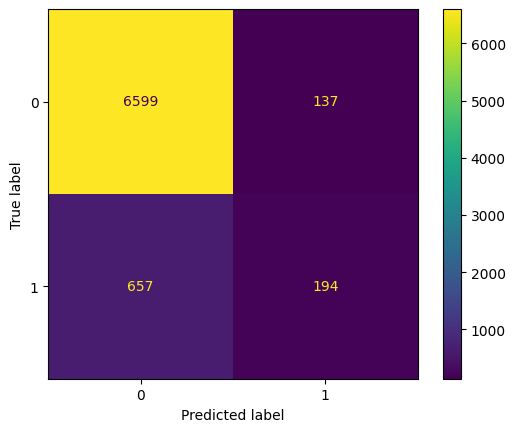

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8957 - loss: 0.2771
Loss and accuracy: [0.2824617624282837, 0.8953472971916199]


In [22]:
preds = np.where(preds >= 0.5, 1, 0)
cm = confusion_matrix(y_test,preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()
plt.show()
print(f'Loss and accuracy: {model.evaluate(X_test,y_test)}')

# Recommendations and Insights and Market Segmentation

In [23]:
result['predictions'] = preds
d = {'no':0,'yes':1,'unknown':2}
result['y'] = result['y'].map(d.get)
result.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,predictions
686,50,housemaid,married,basic.4y,unknown,yes,no,telephone,may,tue,...,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
7076,47,admin.,single,unknown,unknown,no,no,telephone,may,thu,...,0,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,0
16799,54,services,married,high.school,unknown,no,yes,cellular,jul,thu,...,0,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0
13065,27,self-employed,single,professional.course,no,yes,no,cellular,jul,tue,...,0,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0
26486,38,self-employed,married,professional.course,no,no,no,cellular,nov,thu,...,0,1,failure,-0.1,93.200,-42.0,4.076,5195.8,0,0


In [24]:
agg_methods = {}

# Add numeric columns with their aggregation methods
numeric_cols = result.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    agg_methods[col] = ['mean', 'std', 'min', 'max']

# Add categorical columns with their aggregation method (mode)
categorical_cols = result.select_dtypes(include=['bool', 'O']).columns
for col in categorical_cols:
    agg_methods[col] = lambda x: x.mode()[0] if not x.mode().empty else None

# Group by 'y' and 'predictions' and apply the aggregation methods
aggregated_result = result.groupby(['y', 'predictions']).agg(agg_methods)
with pd.option_context('display.max_columns', None):
    print(aggregated_result)

                     age                     campaign                    \
                    mean        std min max      mean       std min max   
y predictions                                                             
0 0            39.561903   9.272821  18  69  2.072435  1.300860   1   6   
  1            40.532847  13.934221  18  69  1.868613  1.174593   1   6   
1 0            38.292237  10.669929  17  69  1.987823  1.237069   1   6   
  1            40.020619  12.635569  18  69  1.608247  0.840142   1   5   

                  pdays                    previous                    \
                   mean       std min max      mean       std min max   
y predictions                                                           
0 0            0.029095  0.507359   0  19  0.119109  0.365697   0   5   
  1            3.656934  4.424926   0  17  1.000000  1.021821   0   4   
1 0            0.196347  1.215795   0  11  0.242009  0.533226   0   4   
  1            4.695876  4.190451   

### We want the the group where y and prediction = 1
#### The characteristics of this group:
#### their ages are between 18 and 69 and most of them are around 40
#### the mean of number of contacts performed during this campaign and for this client is 1.6 which is nearly 2
#### the mean of number of days that passed by after the client was last contacted from a previous campaign is 5 days
#### the  mean of number of contacts performed before this campaign and for this client is nearly 2
#### the mean of emp.var.rate is -2.140556 , of cons.price.idx is 93.462228, of cons.conf.idx is -37.135000, and of euribor3m is 0.834611 
#### the average number of employees is 5015 with minimum of 4964
#### the most dominant job is admin
#### the most dominant marital is married with education of university degree
#### It is most likely not to have credit in defualt or presonal loan, but it is likely that he or she has housing loan
#### the most appropriate contact method is cellular in August month and in Tuesday with success outcome of the previous marketing campaign

# Documentation

## 1. Dataset Overview
### The dataset used is the "Bank Marketing" dataset (bank-additional-full.csv), which contains information about direct marketing campaigns (phone calls) conducted by a Portuguese banking institution. The goal is to predict whether a client will subscribe to a term deposit (y).
### 
### Key columns:
### 
### Numerical: age, campaign, pdays, previous, euribor3m, etc.
### Categorical: job, marital, education, default, housing, loan, etc.
### Target: y (binary: yes or no)
## 2. Data Preprocessing
### Steps taken to clean and preprocess the data:
### 
### Dropping Irrelevant Columns:
### 
### The duration column is dropped because it's only known after the outcome is determined.
### Handling Missing Values:
### 
### Numeric columns: Filled missing values with the mean.
### Categorical columns: Filled missing values with the mode.
### Outlier Removal:
### 
### The pdays column's value 999 is replaced with 0 to facilitate outlier detection.
### For other numeric columns, outliers were detected and removed using the Interquartile Range (IQR) method.
### Some columns were excluded because they have a specific value that is repeated so mush whihc would affect outliers removal and reduce dataset shape greatly
### Feature Engineering:
### 
### A new feature total_contacts was created by combining campaign and previous.
### Dropped less informative columns (day_of_week, campaign, previous).
### Scaling:
### 
### Numeric columns were standardized using StandardScaler.
### Encoding Categorical Variables:
### 
### Label encoding for binary categorical variables (y, default, housing, loan, contact, poutcome).
### One-hot encoding for multi-category variables (job, marital, education, month).
## 3. Exploratory Data Analysis (EDA)
### EDA helped uncover trends and patterns:
### 
### Boxplots: Showed the distribution of numeric features by the target variable y.
### Countplots: Illustrated the distribution of categorical features and their relationship with y.
### Key Findings:
### 
### the least effective numeric columns are 'pdays', 'previous', 'euribor3m'
### if previous column is 0 then it is most likely that y column would be no but when it 1 or 2 then it likely to be yes
### The day_of_week columns seems to be unimportant
### When the job type is admin, marital is married, contact type is cellular, defualt has value of no, poutcome has value of nonexistent, the education is university degree, and has housing loan, then the value of y likely would be yes
## 4. Model Development
### A neural network was developed to predict whether a client would subscribe to a term deposit:
### 
### Model Architecture:
### 
### Input Layer: Corresponding to the number of input features.
### Hidden Layer: Varied nodes (48, 42, ..., 6) with ReLU activation.
### Output Layer: A single node with sigmoid activation for binary classification.
### Model Training:
### 
### Trained on the training data with varying epochs (50, 100, 200, 400, 500).
### Best model: 48 hidden nodes and 200 epochs.
### Evaluation:
### 
### Loss and accuracy were evaluated on the test data.
### Confusion Matrix: Displayed to assess the performance of the model.
## 5. Market Segmentation and Insights
### Using the final model's predictions, the data was segmented into groups for analysis:
### 
### Groups: Based on y and predictions.
### Aggregation: Mean, standard deviation, minimum, and maximum were calculated for numeric columns, mode was calculated for categorical columns.
### Insights:
### Age: Most subscribers are around 40 years old.
### Total Contacts: Average contacts are nearly 2.
### Economic Indicators:
### Mean emp.var.rate: -2.14.
### Mean cons.price.idx: 93.46.
### Mean euribor3m: 0.83.
### Job: Admin jobs are dominant.
### Marital Status: Married clients with a university degree are more likely to subscribe.
### Credit and Loans: Most clients do not have credit defaults or personal loans but may have housing loans.
### Best Contact Method: Cellular, particularly in August, on Tuesdays, with a successful outcome from previous campaigns.
## Conclusion
### The project provides a thorough analysis of the bank's marketing efforts, offering insights into the characteristics of likely subscribers. The final model and segmentation can help the bank target the most promising clients in future campaigns.